In [1]:
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm
from image_utils import *
import torch
import networks
from DegradProcess import batch_degrade, MotionDegrad
from torch import optim
import torch.nn.functional as F
import torch

gpu_id = 0
device = torch.device("cuda:{:d}".format(gpu_id) if torch.cuda.is_available() else "cpu")

### Load Ground-truth HR data

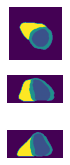

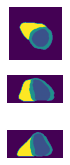

In [2]:
data_dir = './data/HR_demo'
seg_file_path = os.path.join(data_dir, 'demo_HR.nii.gz')
seg_nib = nib.load(seg_file_path)
HR_data = seg_nib.get_fdata()

vol3view(HR_data)

### Load degraded LR data

In [3]:
data_dir = './data/HR_demo'
seg_file_path = os.path.join(data_dir, 'demo_LR.nii.gz')
seg_nib = nib.load(seg_file_path)
seg_data = seg_nib.get_fdata()
affine_sa = seg_nib.affine
seg_LR = torch.Tensor(label2onehot(seg_data)[np.newaxis,:]).to(device)

### Load generative models of HR segmentation

In [4]:
# load model
z_dim, beta = 64, 1e-3
model = networks.GenVAE3D(z_dim=z_dim, img_size=128, depth=64)
model.to(device)
model_path = 'models/betaVAE/VAECE_zdim_{:d}_epoch_100_beta_{:.2E}_alpha.pt'.format(z_dim, beta)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

### Enhance the segmentation by joint motion correction and super resolution

In [5]:
new_D = seg_LR.shape[2]
MotionLayer = MotionDegrad(newD=new_D, mode='nearest')
MotionLayer.to(device)

# LATENT OPTIMISATION
z0 = torch.zeros((1, z_dim)).to(device)
seg_map = torch.argmax(seg_LR, axis=1)

z_recall = z0.clone().detach().requires_grad_(True)

# optimizer for z
optimizer1 = optim.Adam([{'params': z_recall}], lr=0.2)
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=100, gamma=0.5)
# optimizer for motion
optimizer2 = optim.Adam(MotionLayer.parameters(), lr=0.1)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=100, gamma=0.5)

for k in (range(0, 500)):
    # E - step, estimate motion
    optimizer2.zero_grad()
    recon_x = model.decode(z_recall)
    recon_x = MotionLayer(recon_x)
    loss = F.cross_entropy(recon_x, seg_map,reduction='mean')
    loss.backward()
    optimizer2.step()

    # M - step, estimate z
    optimizer1.zero_grad()
    recon_x = model.decode(z_recall)
    recon_x = MotionLayer(recon_x)
    loss = F.cross_entropy(recon_x, seg_map, reduction='mean')
    loss.backward()
    optimizer1.step()

    scheduler1.step()
    scheduler2.step()

SR_data = onehot2label(model.decode(z_recall).squeeze().detach().cpu().numpy())

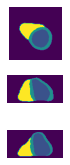

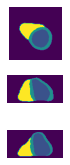

In [6]:
vol3view(SR_data)

In [7]:
### Compare the SR result to Ground-truth HR result

In [8]:
# the translated optimal dice is used because the solution to (SR_seg, d) is not unique
# eg. (HR_seg, 0) and (translated HR_seg, d) will result in the same LR seg
LV_dice, _ = np_categorical_dice_optim(SR_data, HR_data, k=1)
MYO_dice, _ = np_categorical_dice_optim(SR_data, HR_data, k=2)
RV_dice, _ = np_categorical_dice_optim(SR_data, HR_data, k=4)
print('LV DICE: {:0.2f}\nMYO DICE: {:0.2f}\nRV DICE: {:0.2f}'.format(LV_dice, MYO_dice, RV_dice))

LV DICE: 0.96
MYO DICE: 0.88
RV DICE: 0.95
